## Image sample (DDPM - guided diffusion - Diffusion beats gans)

In [1]:
# from __future__ import print_function 
import argparse
import os, sys, glob

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import PIL
import copy
import pytorch_lightning as pl
sys.path.insert(0, '../../')
from guided_diffusion.script_util import (
    seed_all,
)
import importlib

# Sample utils
sys.path.insert(0, '../')
from sample_utils import (
    ckpt_utils, 
    params_utils, 
    vis_utils, 
    file_utils, 
    img_utils, 
    inference_utils, 
    mani_utils,
    attr_mani,
)

In [23]:
# Define loading settings 
# cfg_name = "cond_img64_by_deca_arcface.yaml"
# log_dir = "cond_img64_by_deca_arcface"
# cfg_name = "all_reduce_mult_SharedConv_shaded1.yaml"
# log_dir = "all_reduce_mult_SharedConv_shaded1"
cfg_name = "all_reduce_mult_SharedConv_EncLight_shaded1_adaptivenonzero.yaml"
log_dir = "all_reduce_mult_SharedConv_EncLight_shaded1_adaptivenonzero"
set_ = "valid"
batch_size = 20
seed = 47
seed_all(seed)
if set_ == 'itw':
    img_dataset_path = "../../itw_images/aligned/"
elif set_ == 'train' or set_ == 'valid':
    img_dataset_path = f"/data/mint/ffhq_256_with_anno/ffhq_256/{set_}/"
else: raise NotImplementedError

# Checkpoint loader
step = "900000"
ckpt_selector = "ema"
ckpt_loader = ckpt_utils.CkptLoader(log_dir=log_dir, cfg_name=cfg_name)
cfg = ckpt_loader.cfg
model_dict, diffusion = ckpt_loader.load_model(ckpt_selector=ckpt_selector, step=step)


[#] Model Path :  ['/data/mint/model_logs_mount/v2/all_reduce_mult_SharedConv_EncLight_shaded1_adaptivenonzero/']
['/home/mint/guided-diffusion/config/Normals_All_EncLight/all_reduce_mult_SharedConv_EncLight_shaded1_adaptivenonzero.yaml']
Merging with :  Namespace(cfg='/home/mint/guided-diffusion/config/Normals_All_EncLight/all_reduce_mult_SharedConv_EncLight_shaded1_adaptivenonzero.yaml')

[#] Available ckpt :  ['_000000.pt', '_000000.pt', '_025000.pt', '_025000.pt', '_050000.pt', '_050000.pt', '_075000.pt', '_075000.pt', '_100000.pt', '_100000.pt', '_125000.pt', '_125000.pt', '_150000.pt', '_150000.pt', '_175000.pt', '_175000.pt', '_200000.pt', '_200000.pt', '_225000.pt', '_225000.pt', '_250000.pt', '_250000.pt', '_275000.pt', '_275000.pt', '_300000.pt', '_300000.pt', '_325000.pt', '_325000.pt', '_350000.pt', '_350000.pt', '_375000.pt', '_375000.pt', '_400000.pt', '_400000.pt', '_425000.pt', '_425000.pt', '_450000.pt', '_450000.pt', '_475000.pt', '_475000.pt', '_500000.pt', '_500000.

Key=> shape : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-shape-anno.txt
Key=> pose : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-pose-anno.txt
Key=> exp : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-exp-anno.txt
Key=> cam : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-cam-anno.txt
Key=> light : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-light-anno.txt
Key=> faceemb : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-faceemb-anno.txt


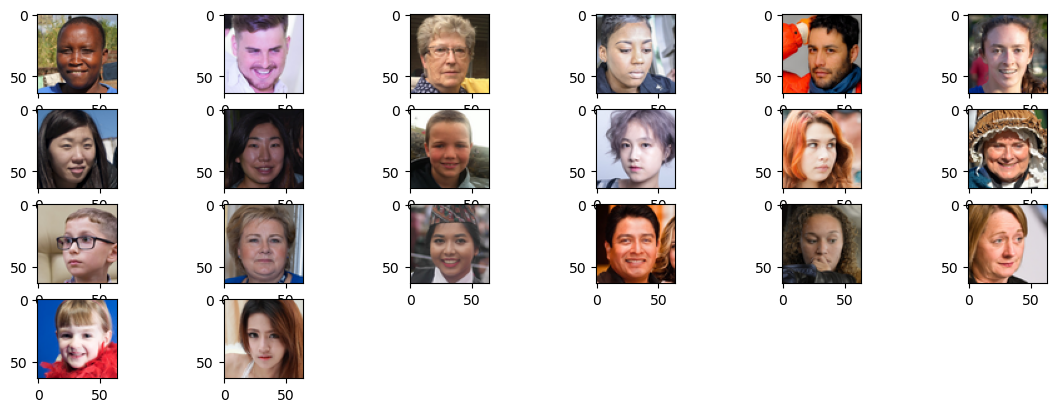

[#] Condition build from parameters in  ['shape', 'pose', 'exp', 'cam', 'faceemb']
(20, 671)


/home/mint/mothership/sample_scripts/ipynb/../sample_utils/inference_utils.py:245: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cond[k] = th.tensor(cond[k]).to(device)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

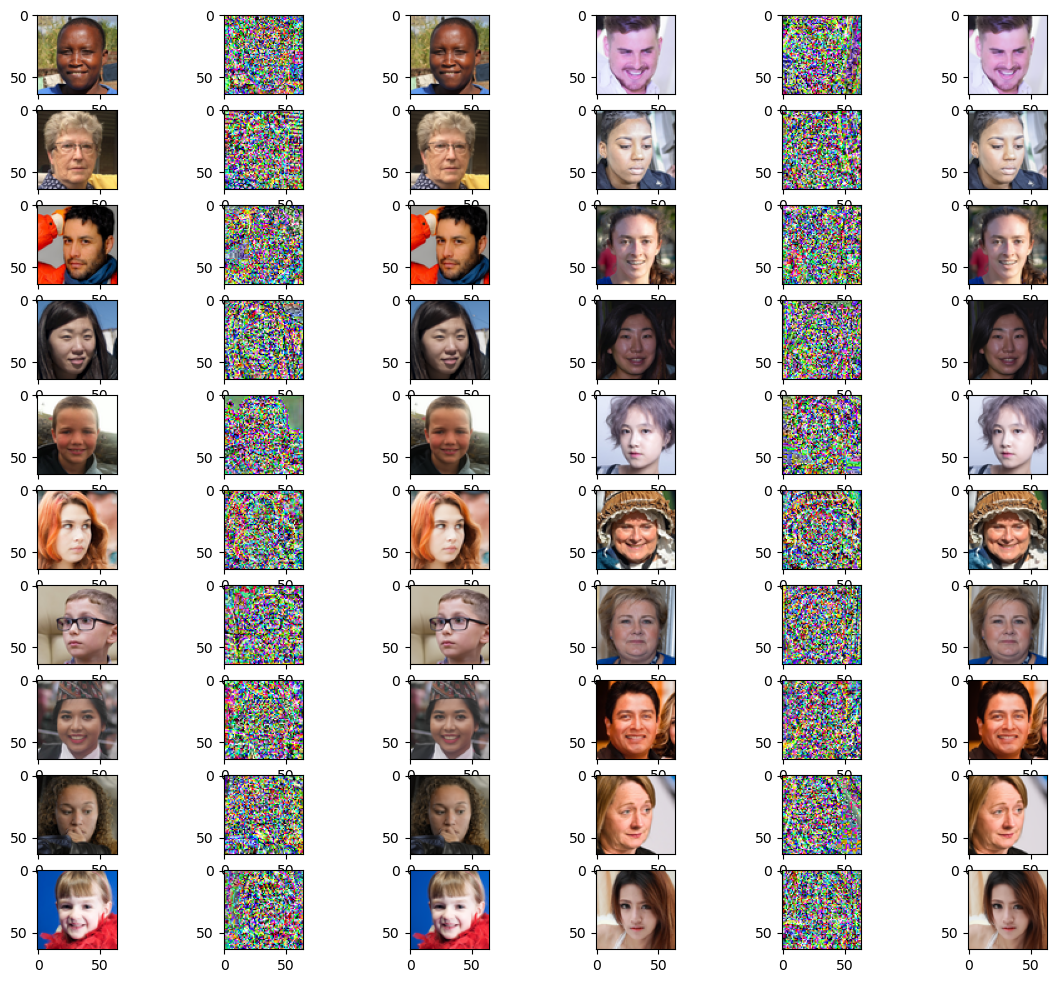

In [17]:
if True:
    # Load params
    params_set = params_utils.get_params_set(set=set_, cfg=cfg)

    rand_idx = np.random.choice(a=range(len(list(params_set.keys()))), replace=False, size=batch_size)
    img_path = file_utils._list_image_files_recursively(img_dataset_path)
    img_path = [img_path[r] for r in rand_idx]
    img_name = [path.split('/')[-1] for path in img_path]

    # Load condition & Images into model_kwargs
    model_kwargs = mani_utils.load_condition(params_set, img_name)
    images = mani_utils.load_image(all_path=img_path, cfg=cfg, vis=True)['image']
    model_kwargs.update({'image_name':img_name, 'image':images})
    base_idx = 11
    mode = {'init_noise':'vary_noise', 'cond_params':'vary_cond'}
    interchange = None

    # Input 
    init_noise = inference_utils.get_init_noise(n=batch_size, mode='fixed_noise', img_size=cfg.img_model.image_size, device=ckpt_loader.device)
    cond = model_kwargs.copy()

    cond_enc = {'light':model_dict['ImgEncoder'](cond['image'].cuda().float())}
    cond['light'] = cond_enc['light']

    # Input 
    init_noise = inference_utils.get_init_noise(n=len(img_name), mode='fixed_noise', img_size=cfg.img_model.image_size, device=ckpt_loader.device)

    # Finalize the cond_params
    key_cond_params = mani_utils.without(cfg.param_model.params_selector, cfg.param_model.rmv_params)
    cond = mani_utils.create_cond_params(cond=cond, key=key_cond_params)
    cond = inference_utils.to_tensor(cond, key=['cond_params', 'light', 'image'], device=ckpt_loader.device)

    # Reverse
    pl_reverse_sampling = inference_utils.PLReverseSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_reverse_sample_loop, cfg=cfg)
    reverse_ddim_sample = pl_reverse_sampling(x=cond['image'], model_kwargs=cond)

    # Forward
    pl_sampling = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_sample_loop, cfg=cfg)
    sample_ddim = pl_sampling(noise=reverse_ddim_sample['img_output'], model_kwargs=cond)

    # Visualization
    fig = vis_utils.plot_sample(img=cond['image'], reverse_sampling_images=reverse_ddim_sample['img_output'], sampling_img=sample_ddim['img_output'])
    plt.show()

Key=> shape : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-shape-anno.txt
Key=> pose : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-pose-anno.txt
Key=> exp : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-exp-anno.txt
Key=> cam : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-cam-anno.txt
Key=> light : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-light-anno.txt
Key=> faceemb : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-faceemb-anno.txt


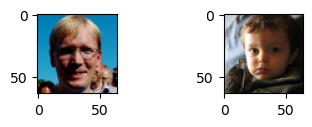

[#] Condition build from parameters in  ['shape', 'pose', 'exp', 'cam', 'faceemb']
(2, 671)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

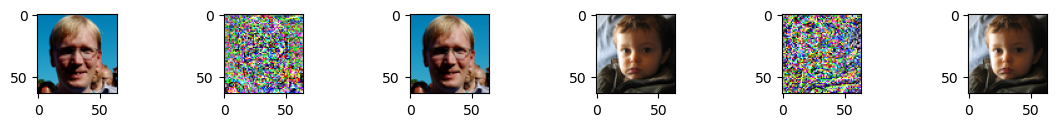

In [18]:
src_ref = '61048.jpg'
dst_ref = '61339.jpg'
params_set = params_utils.get_params_set(set=set_, cfg=cfg)
img_name = [src_ref, dst_ref]
model_kwargs = mani_utils.load_condition(params_set, img_name=img_name)
images = mani_utils.load_image_by_name(img_name=img_name, img_dataset_path=img_dataset_path, cfg=cfg, vis=True)['image']
model_kwargs.update({'image_name':img_name, 'image':images})
cond = model_kwargs.copy()

cond_enc = {'light':model_dict['ImgEncoder'](cond['image'].cuda().float())}
cond['light'] = cond_enc['light']

# Input 
init_noise = inference_utils.get_init_noise(n=len(img_name), mode='fixed_noise', img_size=cfg.img_model.image_size, device=ckpt_loader.device)

# Finalize the cond_params
key_cond_params = mani_utils.without(cfg.param_model.params_selector, cfg.param_model.rmv_params)
cond = mani_utils.create_cond_params(cond=cond, key=key_cond_params)
cond = inference_utils.to_tensor(cond, key=['cond_params', 'light', 'image'], device=ckpt_loader.device)

# Reverse
pl_reverse_sampling = inference_utils.PLReverseSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_reverse_sample_loop, cfg=cfg)
reverse_ddim_sample = pl_reverse_sampling(x=cond['image'], model_kwargs=cond)

pl_sampling = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_sample_loop, cfg=cfg)
sample_ddim = pl_sampling(noise=reverse_ddim_sample['img_output'], model_kwargs=cond)

# Visualization
fig = vis_utils.plot_sample(img=cond['image'], reverse_sampling_images=reverse_ddim_sample['img_output'], sampling_img=sample_ddim['img_output'])
plt.show()

# Encoding Light

Key=> shape : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-shape-anno.txt
Key=> pose : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-pose-anno.txt
Key=> exp : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-exp-anno.txt
Key=> cam : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-cam-anno.txt
Key=> light : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-light-anno.txt
Key=> faceemb : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-faceemb-anno.txt


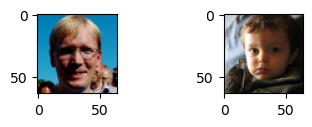

[#] Condition build from parameters in  ['shape', 'pose', 'exp', 'cam', 'faceemb']
(2, 671)


  0%|          | 0/1000 [00:00<?, ?it/s]

[#] Condition build from parameters in  ['shape', 'pose', 'exp', 'cam', 'faceemb']
(30, 671)


  0%|          | 0/1000 [00:00<?, ?it/s]

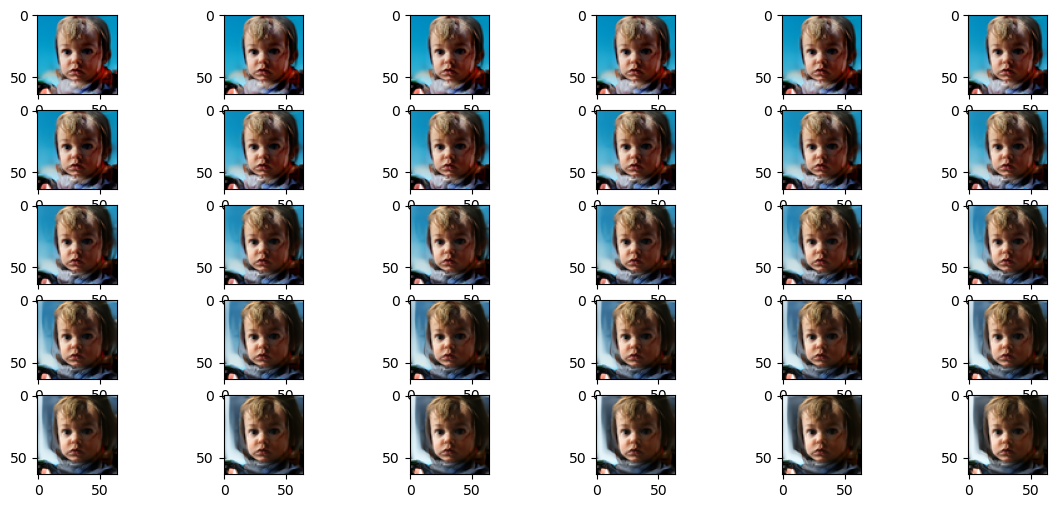

In [20]:
src_ref = '61048.jpg'
dst_ref = '61339.jpg'
params_set = params_utils.get_params_set(set=set_, cfg=cfg)
img_name = [src_ref, dst_ref]
model_kwargs = mani_utils.load_condition(params_set, img_name=img_name)
images = mani_utils.load_image_by_name(img_name=img_name, img_dataset_path=img_dataset_path, cfg=cfg, vis=True)['image']
model_kwargs.update({'image_name':img_name, 'image':images})
cond = model_kwargs.copy()

cond_enc = {'light':model_dict['ImgEncoder'](cond['image'].cuda().float())}
cond['light'] = cond_enc['light']

# Input 
init_noise = inference_utils.get_init_noise(n=len(img_name), mode='fixed_noise', img_size=cfg.img_model.image_size, device=ckpt_loader.device)

# Finalize the cond_params
key_cond_params = mani_utils.without(cfg.param_model.params_selector, cfg.param_model.rmv_params)
cond = mani_utils.create_cond_params(cond=cond, key=key_cond_params)
cond = inference_utils.to_tensor(cond, key=['cond_params', 'light', 'image'], device=ckpt_loader.device)

# Reverse
pl_reverse_sampling = inference_utils.PLReverseSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_reverse_sample_loop, cfg=cfg)
reverse_ddim_sample = pl_reverse_sampling(x=cond['image'], model_kwargs=cond)

# Forward
n=30
interp_cond = mani_utils.iter_interp_cond(cond.copy(), interp_set=['light'], src_idx=0, dst_idx=1, n_step=n)
cond = mani_utils.repeat_cond_params(cond, base_idx=1, n=n, key=mani_utils.without(cfg.param_model.params_selector, ['light']))
cond.update(interp_cond)

# Finalize the cond_params
key_cond_params = mani_utils.without(cfg.param_model.params_selector, cfg.param_model.rmv_params)
cond = mani_utils.create_cond_params(cond=cond, key=key_cond_params)
cond = inference_utils.to_tensor(cond, key=['cond_params', 'light'], device=ckpt_loader.device)

pl_sampling = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_sample_loop, cfg=cfg)
sample_ddim = pl_sampling(noise=th.cat([reverse_ddim_sample['img_output'][[0]]]*n, dim=0), model_kwargs=cond)

# Visualization
# fig = vis_utils.plot_sample(img=cond['image'], reverse_sampling_images=reverse_ddim_sample['img_output'], sampling_img=sample_ddim['img_output'])
fig = vis_utils.plot_sample(img=sample_ddim['img_output'],)
plt.show()

# Linear Classifier

Key=> shape : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-shape-anno.txt
Key=> pose : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-pose-anno.txt
Key=> exp : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-exp-anno.txt
Key=> cam : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-cam-anno.txt
Key=> light : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-light-anno.txt
Key=> faceemb : Filename=>/data/mint/ffhq_256_with_anno/params/valid/ffhq-valid-faceemb-anno.txt


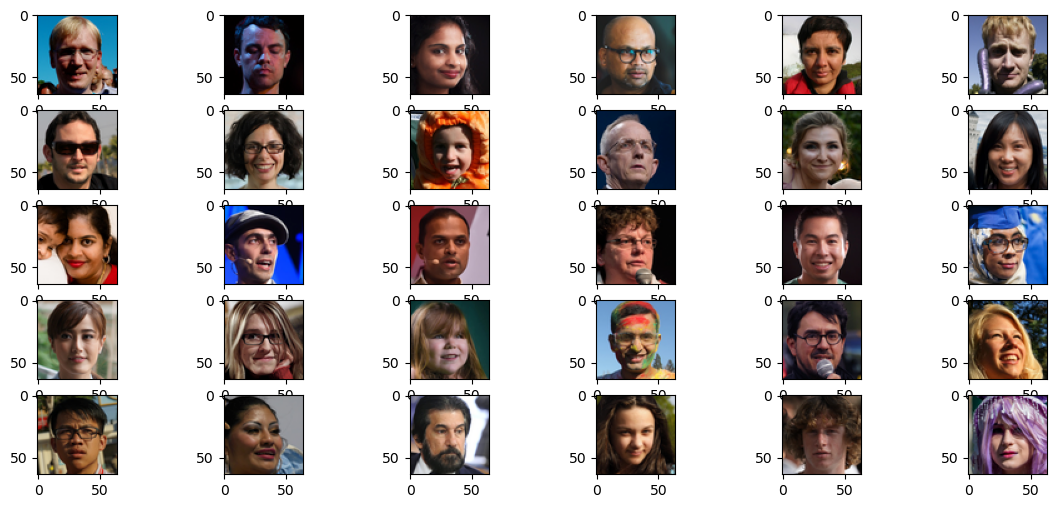

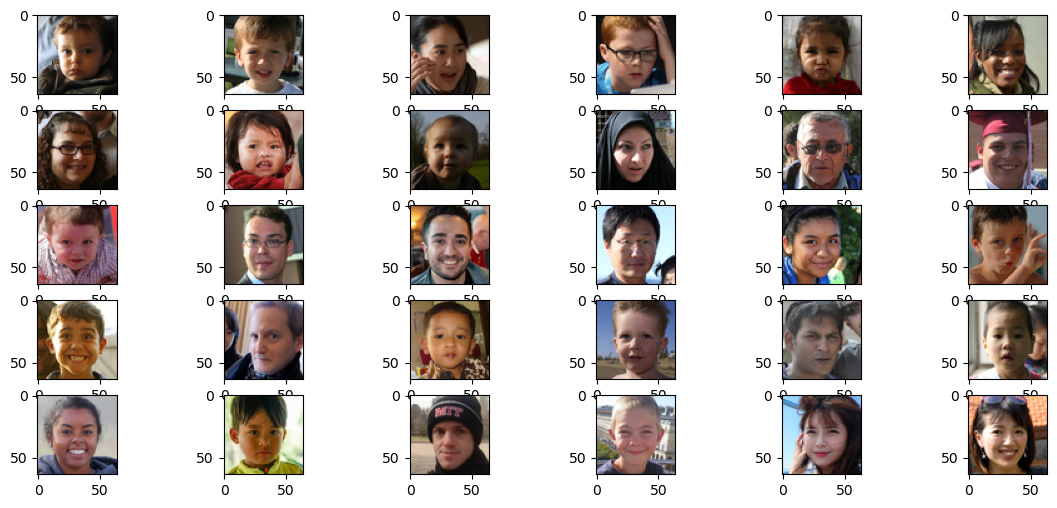

torch.Size([30, 3, 64, 64])


AssertionError: 

In [29]:
'''
Prepare data
 - Positive class = destination = 1
 - Negative class = source = 0
'''
k = 30
params_set = params_utils.get_params_set(set=set_, cfg=cfg)
# Source = label as 0
src_ref = '61048.jpg'
ref_params = params_set[src_ref]['light']
src_images, src_params_dict = attr_mani.retrieve_topk_params(params_set=params_set, cfg=cfg, ref_params=ref_params, img_dataset_path=img_dataset_path, k=k, dist_type='l2')
src_label = th.zeros(k)
# Destination = label as 1
dst_ref = '61339.jpg'
ref_params = params_set[dst_ref]['light']
dst_images, dst_params_dict = attr_mani.retrieve_topk_params(params_set=params_set, cfg=cfg, ref_params=ref_params, img_dataset_path=img_dataset_path, k=k, dist_type='l2')
dst_label = th.ones(k)

print(dst_images.shape)
src_params = [v['light'] for k, v in src_params_dict.items()]
dst_params = [v['light'] for k, v in dst_params_dict.items()]

src_params = model_dict['ImgEncoder'](cond['image'].cuda().float())
print(src_params.shape)
assert False
src_params = np.stack(src_params, axis=0)
dst_params = np.stack(dst_params, axis=0)

input = np.concatenate((src_params, dst_params), axis=0)
input = th.tensor(input)
gt = th.cat((src_label, dst_label))[..., None]


In [25]:
seed_all(47)
cls_model = attr_mani.LinearClassifier(cfg).cuda()
cls_model.train(gt=gt.cuda(), input=input.float().cuda(), n_iters=50000, progress=True)

print("[#] Parameters")
for k, v in cls_model.named_parameters():
    print(k, v, v.shape)

print("[#] Evaluation")
cls_model.evaluate(gt=gt.cuda(), input=input.float().cuda())

print(f"[#] Interpolate Direction = {th.nn.functional.normalize(cls_model.cls.weight, dim=1)}")

[#] Training Linear Classifier with iterations=50000, samples_size=60


[#] Loss = 0.0: 100%|██████████| 50000/50000 [00:21<00:00, 2283.14it/s]                   

[#] Parameters
cls.weight Parameter containing:
tensor([[ 0.98829,  0.97117,  1.16339, -8.39311, -8.51901, -8.39809,  2.59043,
          1.77914,  1.77177,  3.51792,  2.94335,  3.07392, -6.08093, -6.15915,
         -6.21432,  0.69010, -0.25764, -0.54533, -8.15396, -8.08273, -8.02096,
          3.30760,  3.25867,  3.34427, -9.36095, -9.18591, -9.11284]],
       device='cuda:0', requires_grad=True) torch.Size([1, 27])
cls.bias Parameter containing:
tensor([-0.41480], device='cuda:0', requires_grad=True) torch.Size([1])
[#] Evaluation
[#] Accuracy = 100.0
[#] Interpolate Direction = tensor([[ 0.03373,  0.03314,  0.03970, -0.28643, -0.29073, -0.28660,  0.08840,
          0.06072,  0.06046,  0.12005,  0.10045,  0.10490, -0.20752, -0.21019,
         -0.21207,  0.02355, -0.00879, -0.01861, -0.27827, -0.27584, -0.27373,
          0.11288,  0.11121,  0.11413, -0.31946, -0.31348, -0.31099]],
       device='cuda:0', grad_fn=<DivBackward0>)


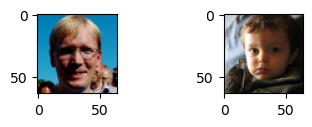

[#] Condition build from parameters in  ['shape', 'pose', 'exp', 'cam', 'faceemb']
(2, 671)


/home/mint/mothership/sample_scripts/ipynb/../sample_utils/inference_utils.py:245: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cond[k] = th.tensor(cond[k]).to(device)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

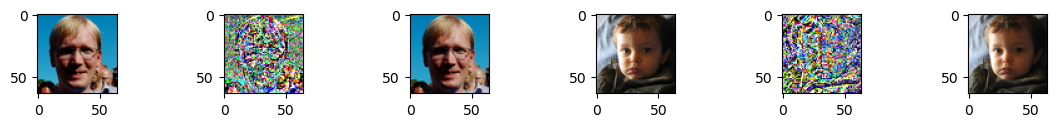

In [26]:
importlib.reload(mani_utils)
img_name = [src_ref, dst_ref]
model_kwargs = mani_utils.load_condition(params_set, img_name=img_name)
images = mani_utils.load_image_by_name(img_name=img_name, img_dataset_path=img_dataset_path, cfg=cfg, vis=True)['image']
model_kwargs.update({'image_name':img_name, 'image':images})
cond = model_kwargs.copy()

cond_enc = {'light':model_dict['ImgEncoder'](cond['image'].cuda().float())}
cond['light'] = cond_enc['light']

# Finalize the cond_params
key_cond_params = mani_utils.without(cfg.param_model.params_selector, cfg.param_model.rmv_params)
cond = mani_utils.create_cond_params(cond=cond, key=key_cond_params)
cond = inference_utils.to_tensor(cond, key=['cond_params', 'light', 'image'], device=ckpt_loader.device)
img_tmp = cond['image'].clone()

# Reverse
pl_reverse_sampling = inference_utils.PLReverseSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_reverse_sample_loop, cfg=cfg)
reverse_ddim_sample = pl_reverse_sampling(x=cond['image'], model_kwargs=cond)

# Forward
pl_sampling = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_sample_loop, cfg=cfg)
sample_ddim = pl_sampling(noise=reverse_ddim_sample['img_output'], model_kwargs=cond)

# Visualization
fig = vis_utils.plot_sample(img=cond['image'], reverse_sampling_images=reverse_ddim_sample['img_output'], sampling_img=sample_ddim['img_output'])
plt.show()


[#] Condition build from parameters in  ['shape', 'pose', 'exp', 'cam', 'faceemb']
(10, 671)


  0%|          | 0/1000 [00:00<?, ?it/s]

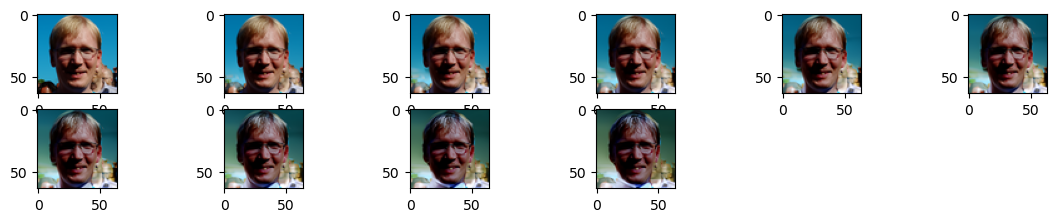

In [27]:
'''
[#] With classifier interpolation
'''
importlib.reload(mani_utils)
n = 10
itp_dir = th.nn.functional.normalize(cls_model.cls.weight, dim=1).detach().cpu().numpy()
cond = model_kwargs.copy()
cond['light'] = model_dict['ImgEncoder'](cond['image'].cuda().float())

interp_cond = mani_utils.interp_by_dir(cond.copy(), src_idx=0, itp_name='light', direction=itp_dir, n_step=n)
cond = mani_utils.repeat_cond_params(cond, base_idx=0, n=n, key=mani_utils.without(cfg.param_model.params_selector, ['light']))
cond.update(interp_cond)
key_cond_params = mani_utils.without(cfg.param_model.params_selector, cfg.param_model.rmv_params)
cond = mani_utils.create_cond_params(cond=cond, key=key_cond_params)
cond = inference_utils.to_tensor(cond, key=['cond_params', 'light'], device=ckpt_loader.device)

# Forward
pl_sampling = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_sample_loop, cfg=cfg)
sample_ddim = pl_sampling(noise=th.cat([reverse_ddim_sample['img_output'][[0]]]*n, dim=0), model_kwargs=cond)

fig = vis_utils.plot_sample(img=sample_ddim['img_output'],)
plt.show()

In [28]:
'''
[#] Without classifier interpolation
'''
cond = model_kwargs.copy()
cond['light'] = model_dict['ImgEncoder'](cond['image'].cuda().float())

interp_cond = mani_utils.iter_interp_cond(cond.copy(), interp_set=['light'], src_idx=0, dst_idx=1, n_step=n)
cond = mani_utils.repeat_cond_params(cond, base_idx=0, n=n, key=mani_utils.without(cfg.param_model.params_selector, ['light']))
cond.update(interp_cond)

# Finalize the cond_params
key_cond_params = mani_utils.without(cfg.param_model.params_selector, cfg.param_model.rmv_params)
cond = mani_utils.create_cond_params(cond=cond, key=key_cond_params)
cond = inference_utils.to_tensor(cond, key=['cond_params', 'light'], device=ckpt_loader.device)

# Forward
pl_sampling = inference_utils.PLSampling(model_dict=model_dict, diffusion=diffusion, sample_fn=diffusion.ddim_sample_loop, cfg=cfg)
sample_ddim = pl_sampling(noise=th.cat([reverse_ddim_sample['img_output'][[0]]]*n, dim=0), model_kwargs=cond)

fig = vis_utils.plot_sample(img=sample_ddim['img_output'],)
plt.show()

[#] Condition build from parameters in  ['shape', 'pose', 'exp', 'cam', 'faceemb']
(10, 671)


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 